In [1]:
#To do lambdaの外部入力
using SparseIR
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
#using DoubleFloats

In [2]:
# Set work data Type
T = Float64x2
#T = BigFloat

MultiFloat{Float64, 2}

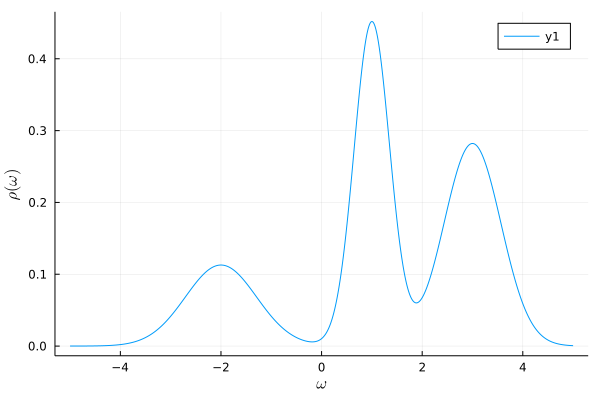

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

#on-centered gaussian
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#rho(omega) = gaussian(omega, 1.0, 0.15) +
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

######

#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

#off-centered gaussian
#rho(omega) = gaussian(omega, 0.2, 0.05) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
beta = 100
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;
#=
plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
#plt.legend()
=#

In [5]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

38

In [6]:
setprecision(128)
;

In [7]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{T}(undef, hnw) 
;

In [8]:
# 元々倍精度のデータをString経由でBigFloatに変換すると精度が下がる
#for i in 1:hnw
    #test_smpl[i]= parse(BigFloat, string(IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta))
    #test_gw[i]  = parse(BigFloat, string(real(gw[hnw+i]))) + parse(BigFloat, string(imag(gw[hnw+i])))*im
#end
for i in 1:hnw
    test_smpl[i]= IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta
    test_gw[i]  = gw[hnw+i]
end

In [16]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H         =  8
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 71
println("N_imp $(N_imag)")
@time result    = Nevanlinna.Nevanlinna_Schur(N_imag, test_smpl, test_gw, N_real, omega_max, eta, H, true)
opt_real = result[2]
;

N_imag is setted as 33
N_imp 33
Pick matrix is positive semi-definite.
Iter     Function value   Gradient norm 
     0     1.388255e-01     4.855332e-01
 * time: 0.02189493179321289


     1     1.124142e-01     3.775988e-01
 * time: 1.1293189525604248


     2     7.243579e-02     2.838218e-01
 * time: 1.1509900093078613


     3     3.638893e-02     1.634163e-01
 * time: 1.1728990077972412


     4     1.124620e-02     5.134421e-02
 * time: 1.2057149410247803


     5     7.218043e-03     3.293351e-02
 * time: 1.229625940322876


     6     3.814718e-03     3.103881e-02
 * time: 1.265509843826294


     7     1.552301e-03     1.432012e-02
 * time: 1.3014719486236572


     8     1.095895e-03     4.637955e-03
 * time: 1.37471604347229


     9     1.012484e-03     3.713669e-03
 * time: 1.4071550369262695


    10     9.447584e-04     3.965103e-03
 * time: 1.4397549629211426


    11     8.460538e-04     5.099243e-03
 * time: 1.4720089435577393


    12     7.680026e-04     1.727517e-03
 * time: 1.5042829513549805


    13     7.470902e-04     1.706685e-03
 * time: 1.5374250411987305


    14     7.133518e-04     2.735397e-03
 * time: 1.5955109596252441


    15     6.765925e-04     2.087565e-03
 * time: 1.627910852432251


    16     5.953661e-04     3.805528e-03
 * time: 1.6710638999938965


    17     4.743766e-04     3.497991e-03
 * time: 1.7032639980316162


    18     4.471122e-04     1.524935e-03
 * time: 1.7354729175567627


    19     4.067431e-04     4.590928e-03
 * time: 1.7782618999481201


    20     2.938151e-04     3.989468e-03
 * time: 1.8315379619598389


    21     2.661878e-04     1.179046e-03
 * time: 1.8639278411865234


    22     2.563843e-04     1.418022e-03
 * time: 1.8962738513946533


    23     2.381980e-04     2.092647e-03
 * time: 1.9284789562225342


    24     1.847400e-04     1.309048e-03
 * time: 1.9606149196624756


    25     1.603911e-04     9.578867e-04
 * time: 1.9927890300750732


    26     1.468499e-04     6.546140e-04
 * time: 2.0365209579467773


    27     1.441997e-04     6.807050e-04
 * time: 2.0688278675079346


    28     1.390184e-04     6.134553e-04
 * time: 2.1011459827423096


    29     1.303402e-04     6.312453e-04
 * time: 2.133378028869629


    30     1.178495e-04     8.382009e-04
 * time: 2.1656179428100586


    31     1.112858e-04     2.779409e-04
 * time: 2.197819948196411


    32     1.105306e-04     1.718316e-04
 * time: 2.230015993118286


    33     1.102917e-04     1.738857e-04
 * time: 2.273810863494873


    34     1.085685e-04     5.254696e-04
 * time: 2.316941976547241


    35     1.060419e-04     2.964854e-04
 * time: 2.3493449687957764


    36     1.053765e-04     1.160606e-04
 * time: 2.381549835205078


    37     1.052733e-04     6.570444e-05
 * time: 2.413712978363037


    38     1.052443e-04     5.016004e-05
 * time: 2.445802927017212


    39     1.052064e-04     6.231308e-05
 * time: 2.489393949508667


    40     1.050991e-04     1.013924e-04
 * time: 2.5216808319091797


    41     1.048344e-04     1.156963e-04
 * time: 2.5540168285369873


    42     1.044391e-04     9.923969e-05
 * time: 2.5861759185791016


    43     1.042440e-04     4.622418e-05
 * time: 2.618389844894409


    44     1.042138e-04     3.300329e-05
 * time: 2.650538921356201


    45     1.042077e-04     2.558394e-05
 * time: 2.683393955230713


    46     1.041853e-04     4.199399e-05
 * time: 2.726517915725708


    47     1.040724e-04     9.795190e-05
 * time: 2.7696478366851807


    48     1.036136e-04     1.563502e-04
 * time: 2.8018078804016113


    49     1.032452e-04     7.872865e-05
 * time: 2.8340399265289307


    50     1.030670e-04     5.676576e-05
 * time: 2.8660948276519775


    51     1.030388e-04     5.893336e-05
 * time: 2.909878969192505


    52     1.030211e-04     4.352412e-05
 * time: 2.9421298503875732


    53     1.028592e-04     9.709873e-05
 * time: 2.9852418899536133


    54     1.024286e-04     1.812418e-04
 * time: 3.0174388885498047


    55     1.005754e-04     3.401694e-04
 * time: 3.0496528148651123


    56     9.628681e-05     4.949183e-04
 * time: 3.081702947616577


    57     8.684283e-05     4.587097e-04
 * time: 3.1253960132598877


    58     8.131715e-05     1.432986e-04
 * time: 3.157778024673462


    59     8.093066e-05     4.745593e-05
 * time: 3.190239906311035


    60     8.089995e-05     1.097026e-05
 * time: 3.211871862411499


    61     8.089841e-05     1.923898e-06
 * time: 3.2334189414978027


    62     8.089827e-05     1.317838e-06
 * time: 3.2656049728393555


    63     8.089826e-05     3.929414e-07
 * time: 3.287045955657959


    64     8.089826e-05     1.076843e-07
 * time: 3.3084678649902344


    65     8.089826e-05     3.526004e-08
 * time: 3.341480016708374


    66     8.089826e-05     1.382624e-08
 * time: 3.3630568981170654


    67     8.089826e-05     3.671972e-09
 * time: 3.384603977203369


max_theta=0.5138761741741645742543340817599947
hardy optimization was success.
 12.799366 seconds (33.35 M allocations: 2.544 GiB, 5.30% gc time, 81.85% compilation time)


In [24]:
ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(N_imag, test_smpl, test_gw)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H)

Nevanlinna.evaluation(raw_reals, abcd, H, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{MultiFloat{Float64, 2}}
RealDomainData{MultiFloat{Float64, 2}}
max_theta=0.0
hardy optimization was success.


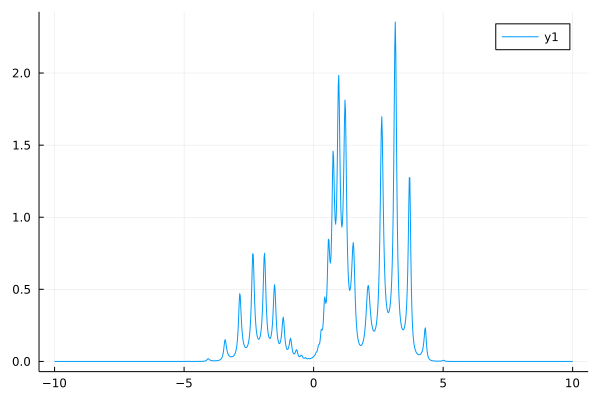

In [21]:
plot(real.(raw_reals.freq), imag.(raw_reals.val))

In [22]:
tmp =  sum(Float64.(imag.(opt_real.val))/pi)*((2.0*opt_real.omega_max)/opt_real.N_real)
abs(1-tmp)^2

1.138607062239803e-6

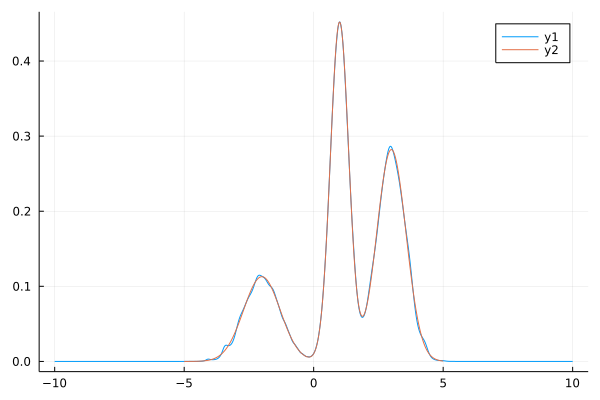

In [23]:
#plt.plot(Float64.(real.((opt_real.freq))), Float64.(imag.(opt_real.val))/pi)
#plt.plot(omegas, rho.(omegas))
#plt.xlim(-5,5)
plot()
plot!(Float64.(real.((opt_real.freq))), Float64.(imag.(opt_real.val))/pi)
plot!(omegas, rho.(omegas))

In [14]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [15]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#